# Import
---

In [171]:
from src.read_csi_csv import read_csi_csv
from src.preprocessing import smooth_csi, normalize_csi
from scipy.signal import savgol_filter
from src.plot import plot
import pandas as pd
import numpy as np
import sys,os

import warnings
warnings.filterwarnings('ignore')

# Set path
---

In [172]:
path = os.path.abspath(".")
sys.path.insert(0, path) # location of src 


In [173]:
relative_path = "csi_data/walk/walk_10.csv"
FILE_PATH = os.path.join(path,relative_path)

# Load CSV
---

In [174]:

# Step 1: Load CSV
df = read_csi_csv(FILE_PATH)

# Assume subcarriers are in columns: sc1, sc2, ..., sc30
subcarrier_columns = [col for col in df.columns if 'subcarrier' in col.lower()]
csi_data = df[subcarrier_columns].values  # numpy arr
csi_data.shape

Loaded CSI data with shape: (39, 65)


(39, 64)

# Normalization
---

In [175]:
csi_array = np.array(csi_data, dtype=np.complex64)
csi_array

array([[   -6.  -35.j,  1130.+1080.j,  1110. +744.j, ...,   745.+2291.j,
          905.+2022.j,  1016.+1735.j],
       [  -25.  -12.j,  1469. -301.j,  1152. -429.j, ...,  2341. +517.j,
         2182. +287.j,  1986.  +74.j],
       [   16.  -35.j,  1592. -221.j,   280.-1296.j, ...,  -478.-2446.j,
        -2252. -521.j, -1265.+1683.j],
       ...,
       [  -15.  +17.j,    13.-1721.j,  -473.-1461.j, ...,  2081.-1129.j,
         1634.-1490.j,  1128.-1733.j],
       [   -4.  +26.j,  -940.-1738.j, -1184.-1279.j, ...,   838.-2597.j,
          338.-2530.j,  -140.-2381.j],
       [   14.  -15.j,   589. +365.j,   779. -221.j, ...,  -106. -759.j,
         -529. -300.j,  -461. +277.j]], shape=(39, 64), dtype=complex64)

In [176]:
# Step 2: Smoothing
real_smoothed = savgol_filter(csi_array.real, window_length=5, polyorder=2, axis=0)
imag_smoothed = savgol_filter(csi_array.imag, window_length=5, polyorder=2, axis=0)
# smoothed_csi = smooth_csi(csi_data, window_size=5)


# Step 3: Normalization
real_normalized = normalize_csi(real_smoothed)
imag_normalized = normalize_csi(imag_smoothed)


# Plot
---


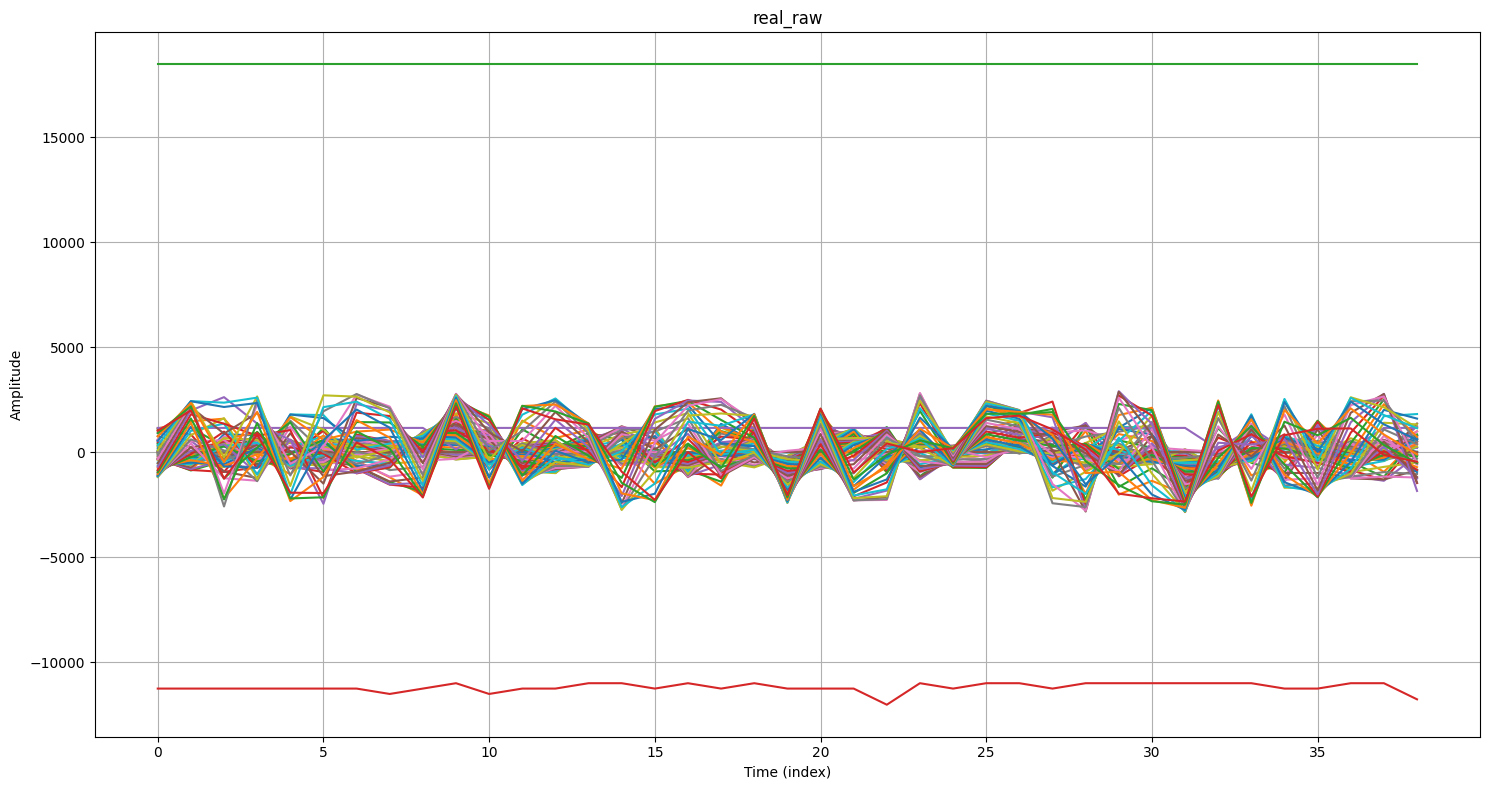

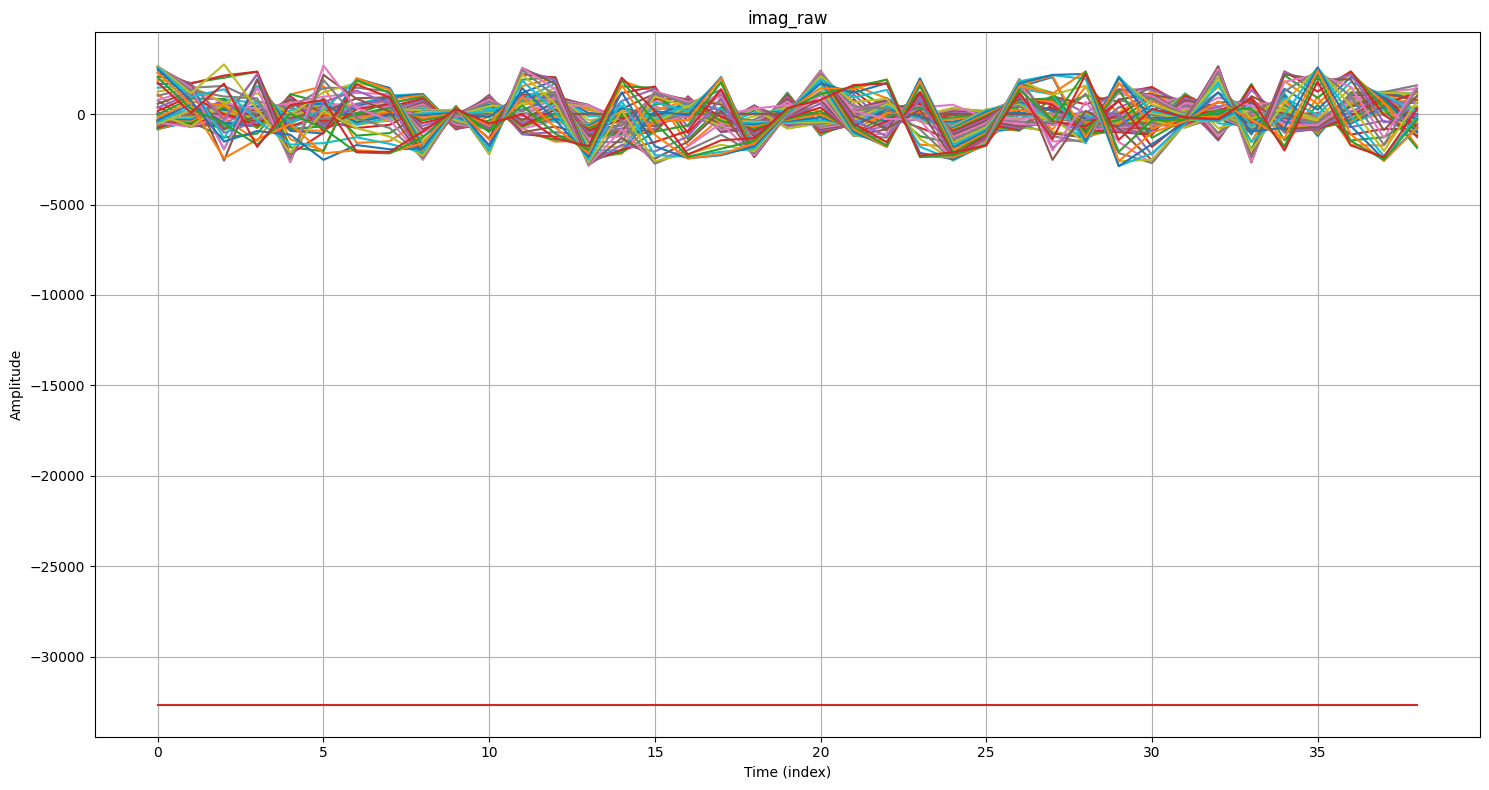

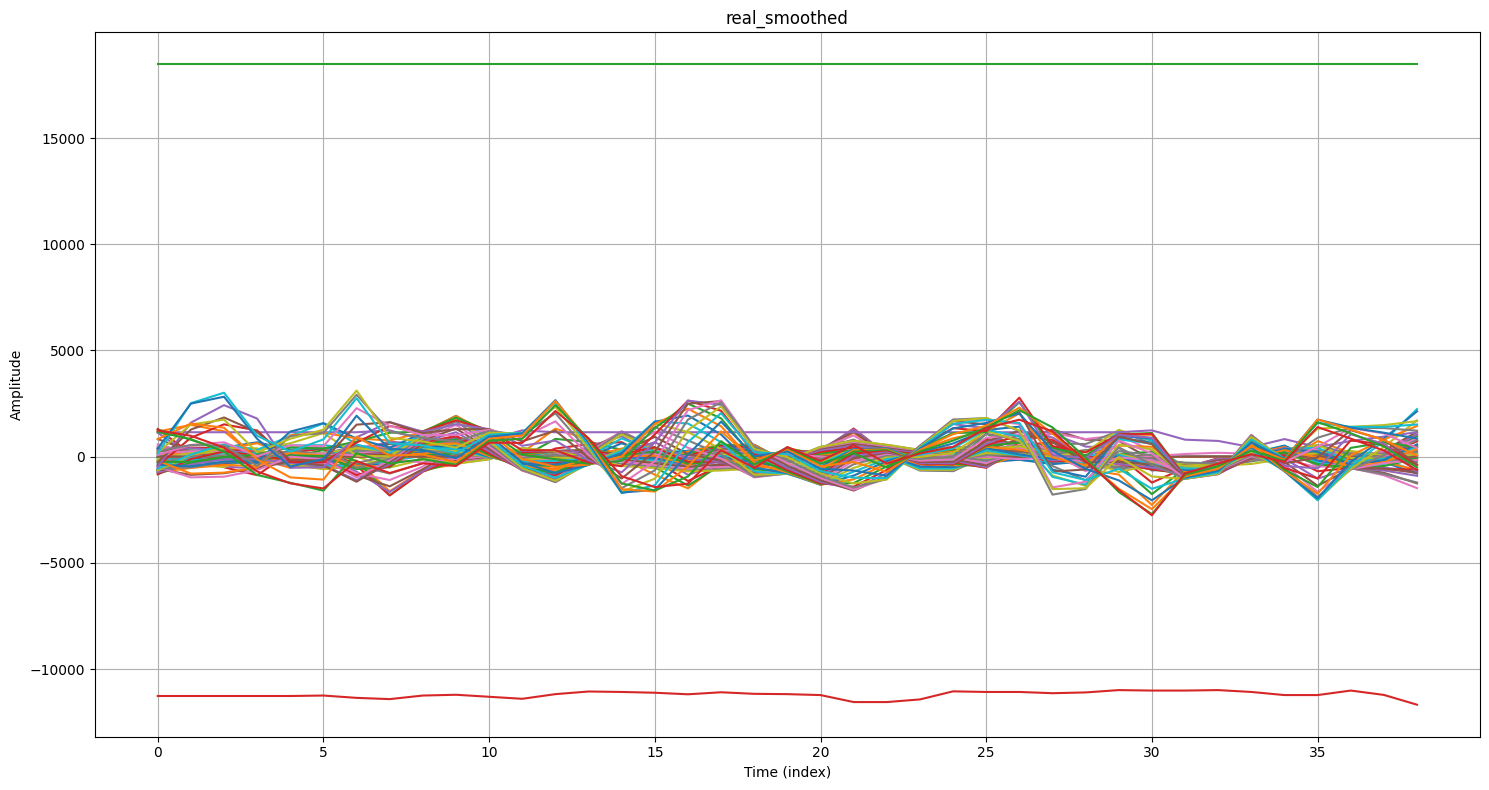

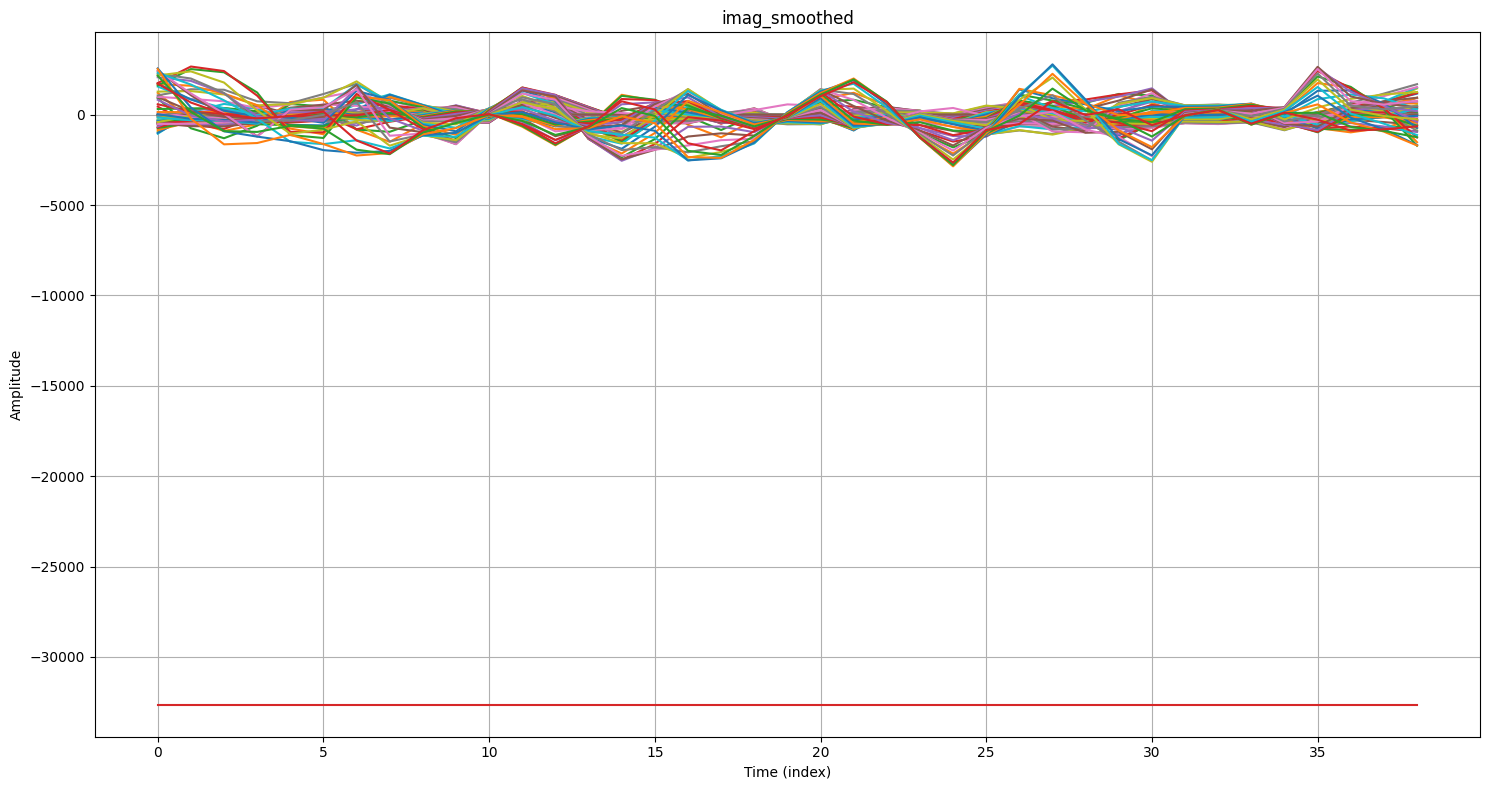

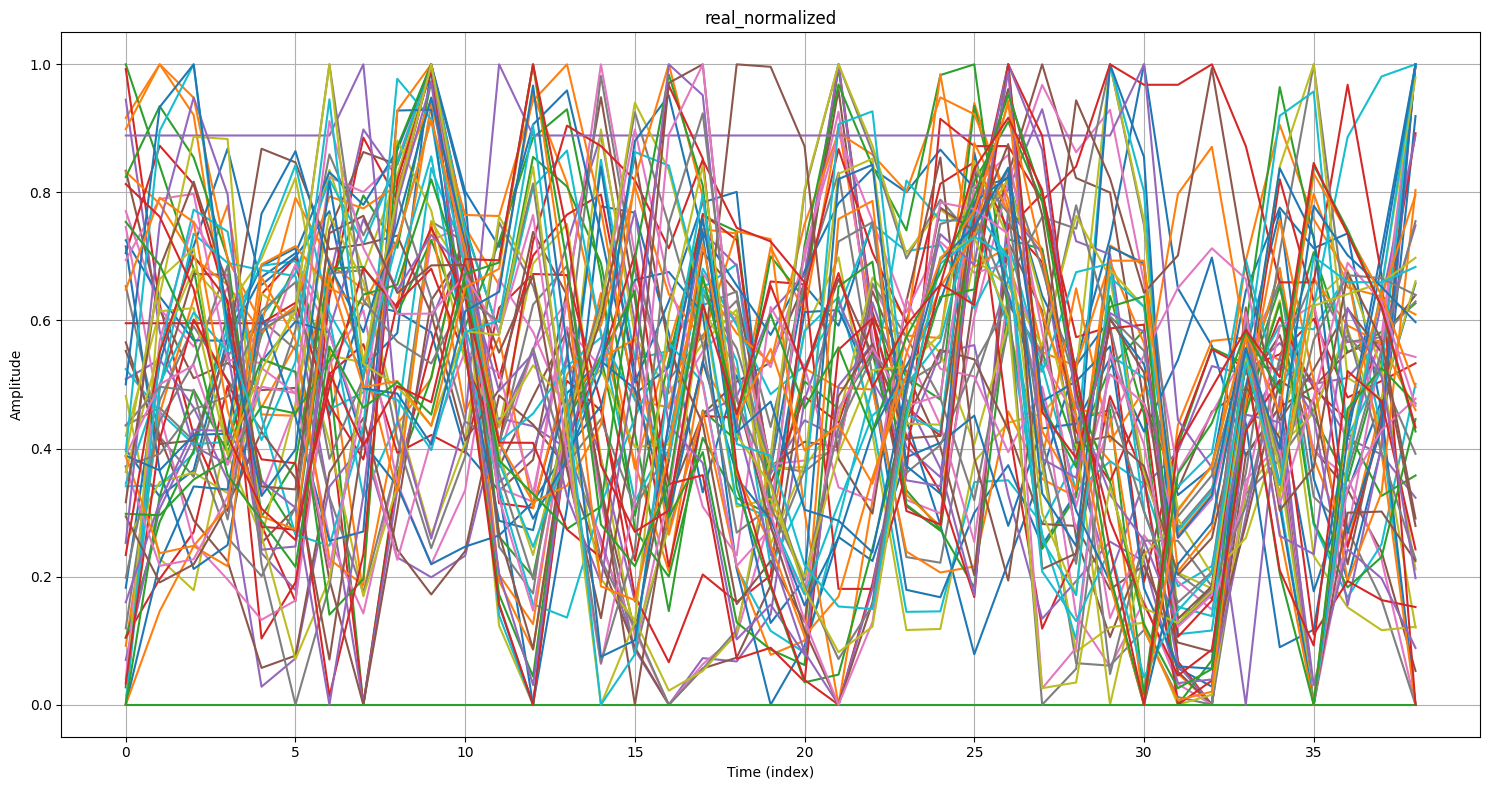

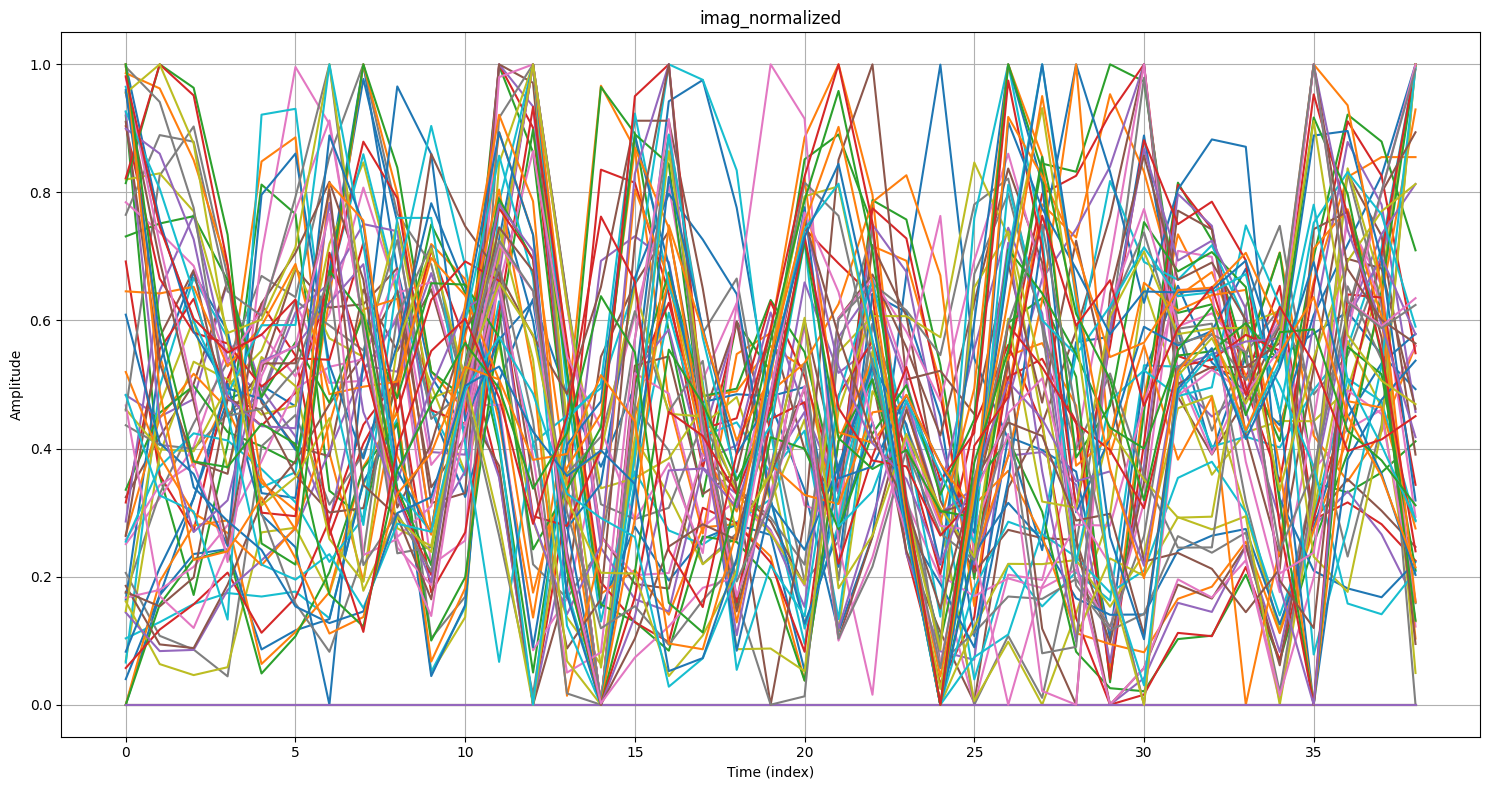

In [177]:
plot(csi_array.real,title="real_raw")
plot(csi_array.imag,title="imag_raw")

plot(real_smoothed,title="real_smoothed")
plot(imag_smoothed,title="imag_smoothed")

plot(real_normalized,title="real_normalized")
plot(imag_normalized,title="imag_normalized")


# Predict
---

In [182]:
import os
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

def parse_complex(s):
    try:
        return complex(s.replace('(', '').replace(')', '').replace(' ', ''))
    except:
        return complex(0, 0)
    
def load_csi_from_csv(file_path):
    df = pd.read_csv(file_path)
    df = df.drop(columns=['timestamp'])
    # แปลงจาก complex string เป็น complex จริง
    csi = df.applymap(lambda x: complex(x.replace('(', '').replace(')', '')))
    return csi.to_numpy()

def extract_features(csi_data):
    # flatten complex array เป็น real/imag ต่อกัน เช่น [r1,i1, r2,i2,...]
    real = np.real(csi_data)
    imag = np.imag(csi_data)
    combined = np.concatenate([real, imag], axis=1)
    return combined.mean(axis=0)  # average over time

def load_dataset_from_structure(root_folder):
    X = []
    y = []
    for activity in os.listdir(root_folder):
        activity_path = os.path.join(root_folder, activity)
        if not os.path.isdir(activity_path):
            continue
        for file in os.listdir(activity_path):
            if file.endswith(".csv"):
                file_path = os.path.join(activity_path, file)
                csi = load_csi_from_csv(file_path)
                feature = extract_features(csi)
                X.append(feature)
                y.append(activity)
    return np.array(X), np.array(y)

root_folder = f"{path}/csi_data"
X, y = load_dataset_from_structure(root_folder)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ใช้ StandardScaler + SVM เป็น pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', C=10, gamma='scale'))
])

# Train
pipeline.fit(X_train, y_train)

# Evaluate
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

print(y_pred)
print(y_test)

              precision    recall  f1-score   support

         sit       1.00      0.50      0.67         2
      sit-up       0.00      0.00      0.00         4
       stand       0.00      0.00      0.00         0
        walk       0.00      0.00      0.00         1
        wave       0.00      0.00      0.00         4

    accuracy                           0.09        11
   macro avg       0.20      0.10      0.13        11
weighted avg       0.18      0.09      0.12        11

['wave' 'walk' 'sit-up' 'walk' 'stand' 'walk' 'wave' 'sit-up' 'sit'
 'stand' 'wave']
['sit-up' 'wave' 'wave' 'sit-up' 'wave' 'sit' 'sit-up' 'wave' 'sit' 'walk'
 'sit-up']


# สรุป
---

การทดลองโดยการใช้ข้อมูล CSI อย่างเดียวในการทำนายไม่เวิร์ค